# **wthscrpr.py**
> ### Weather Scraper (wthscrpr.py) - Downloads data from meteociel.fr and formats it to produce clean .wth and .csv files for Building Energy Simulation Softwares (EnergyPlus, LBT for GH, CoDyBa/KoZiBu, ....)
### Nicolas Désilles (nicolas@ndlabs.fr) - 2022/2023 - PIRD 5GCU INSA Lyon

## A - Importation des modules Python nécessaires

In [38]:
import requests, os
from bs4 import BeautifulSoup
import calendar
import pandas as pd
import time
import pvlib
import math
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.cm import ScalarMappable
import urllib3
urllib3.disable_warnings()

In [41]:
%%html
<style>
table {float:left}
</style>



## B - Définition des fonctions auxiliaires

### B.1 - calculateSunData

Détermine l'azimuth et l'élévation du soleil, le flux direct horizontal et le flux diffus horizontal à partir de la date, des coordonnées latitude/longitude, de la température et de la pression avec la librairie PvLib

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_year_** | int | Année de la date |
| **_month_** | int | mois de la date |
| **_day_** | int | jour de la date |
| **_hour_** | int | heure de la date |
| **_coordinates_** | Pandas.DataFrame object | DataFrame contenant les colonnes 'latitute', 'longitude', et 'altitude' |
| **_temp_** | float | température en [$K$] |
| **_pressure_** | float | pression en [$Pa$] |
| **_loc_** | PvLib.Location object | instance de classe de localisation propre à la librairie PvLib |

#### Sorties

| Sortie | Type | Description |
| --- | --- | --- |
| **_sunAzimuth_** | float | Azimuth du soleil en [°] |
| **_sunElevation_** | float | Hauteur de soleil en [°] |
| **_fluxDirH_** | float | Flux direct horizontal en [$W.m^{-2}$] |
| **_fluxDiffH_** | float | Flux diffus horizontal en [$W.m^{-2}$] |
| **_currentDate_** | str | Chaine de caractère correspondant à la date actuelle complète |


In [24]:
def calculateSunData(year, month, day, hour, coordinates, temp, pressure, loc):

    strHour = str(hour)
    if len(strHour) < 2:
        strHour = "0" + strHour

    currentDate = str(year)+"-"+str(month)+"-"+str(day)+" "+strHour+"-"+"00-00"
    datetimeIndex = pd.to_datetime([currentDate])

    solarPosition = pvlib.solarposition.get_solarposition(
        datetimeIndex,
        coordinates['latitude'],
        coordinates['longitude'],
        coordinates['altitude'],
        pressure*100,
        temperature=temp
    )

    sunAzimuth = solarPosition['azimuth'].item() - 180
    if sunAzimuth <= -90 or sunAzimuth >= 90:
        sunAzimuth = 0
    sunElevation = solarPosition['apparent_elevation'].item()
    if sunElevation <= 0:
        sunElevation = 0

    clearsky = loc.get_clearsky(datetimeIndex, model='ineichen', solar_position=solarPosition)
    fluxDirH = clearsky['dhi'].item()
    fluxDiffH = clearsky['ghi'].item() - fluxDirH

    

    return sunAzimuth, sunElevation, fluxDirH, fluxDiffH, currentDate

### B.2 - calculateDewPointTemp

Calcule la température du point de rosée avec la loi de Heinrich Gustav Magnus-Tetens (https://fr.wikipedia.org/wiki/Point_de_rosée)

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_a_** | float | Constante (égale à 17.27) |
| **_b_** | float | Constante (égale à 237,7 [$°C$]) |
| **_T_** | float | Température de l'air mesurée [$°C$] |
| **_phi_** | float | Humidité relative de l'air (entre 0 et 1, sans unité) |

#### Sorties

| Sortie | Type | Description |
| --- | --- | --- |
| **_dewPointTemp_** | float | Température du point de rosée |

In [43]:
def calculateDewPointTemp(a, b, T, phi):

    alpha = (a*T)/(b + T) + math.log(phi)
    dewPointTemp = (b*alpha)/(a - alpha)

    return dewPointTemp

### B.3 - calculateTempSky

Calcule la température lointaine du ciel avec la loi de Stephan-Boltzmann (https://www.encyclopedie-environnement.org/zoom/refroidissement-vient-du-ciel/)

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_tempAir_** | float | Température de l'air [$°C$] |
| **_humidity_** | float | Humidité relative de l'air [$\%$] |

#### Sorties

| Sortie | Type | Description |
| --- | --- | --- |
| **_tempSky_** | float | Température lointaine du ciel |

In [26]:
def calculateTempSky(tempAir, humidity):

    #Step 1 : Calculate dew-point temperature with Heinrich Gustav Magnus-Tetens law (https://fr.wikipedia.org/wiki/Point_de_rosée)
    tempDP = calculateDewPointTemp(a=17.27, b=237.7, T=tempAir, phi=humidity/100)

    #Step 2 : Estimate global sky emissivity (http://solar.unl.edu/documents/SOL_26.pdf)
    epsSky = 0.73223 + 0.006349*tempDP

    #tempSky calculated with air temp, sky emmissivity, and Stephan-Boltzman Law (https://www.encyclopedie-environnement.org/zoom/refroidissement-vient-du-ciel/)
    tempSky = tempAir*((epsSky)**(1/4))

    return tempSky

### B.4 - addNewWthDataEntry

Ajoute une nouvelle entrée complète de données météo dans la base de données Panda

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_wthData_** | Pandas.DataFrame object | DataFrame Pandas des données météo formatées en construction |
| **_hour_** | int | Heure de l'année |
| **_temp_** | int | Température de l'air [$°C$] |
| **_fluxDirH_** | float | Flux direct horizontal en [$W.m^{-2}$] |
| **_fluxDiffH_** | float | Flux diffus horizontal en [$W.m^{-2}$] |
| **_humidity_** | float | Humidité relative de l'air [$\%$] |
| **_sunAzimuth_** | float | Azimuth du soleil en [°] |
| **_sunElevation_** | float | Hauteur de soleil en [°] |
| **_tempSky_** | float | Température lointaine du ciel |
| **_windSpeed_** | int | Humidité relative de l'air [$\%$] |
| **_windDir_** | int | Humidité relative de l'air [$\%$] |
| **_currentTime_** | str | Chaine de caractère correspondant à la date actuelle complète |

#### Sorties

| Sortie | Type | Description |
| --- | --- | --- |
| **_newDF_** | Pandas.DataFrame object | DataFrame Pandas des données météo concaténé avec la nouvelle ligne |

In [27]:
def addNewWthDataEntry(wthData, hour, temp, fluxDirH, fluxDiffH, humidity, sunAzimuth, sunElevation, tempSky, windSpeed, windDir, currentTime):

    newDataEntry = pd.DataFrame({
                    'Heure':[hour],
                    'Température Air':[temp],
                    'Flux Direct Horizontal':[fluxDirH],
                    'Flux Diffus Horizontal':[fluxDiffH],
                    'Humidité Relative':[humidity],
                    'Azimut du soleil':[sunAzimuth],
                    'Hauteur du soleil':[sunElevation],
                    'Température du ciel':[tempSky],
                    'Vitesse du vent':[windSpeed],
                    'Direction du vent':[windDir],
                    'CurrentTime':[currentTime]
                })

    newDF = pd.concat([wthData,newDataEntry]).reset_index(drop=True)

    return newDF

### B.5 - cleanParsedData

Fonction auxilliaire de nettoyage et formatage des données brutes récupérées depuis le site web

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_parsedTemp_** | str | Chaîne de caractère contenant la température téléchargée |
| **_parsedHumidity_** | str | Chaîne de caractère contenant l'humidité relative téléchargée |
| **_parsedPressure_** | str | Chaîne de caractère contenant la pression atmosphérique téléchargée |
| **_parsedWindSpeed_** | str | Chaîne de caractère contenant la vitesse du vent téléchargée |
| **_parsedWindDir_** | str | Chaîne de caractère contenant la direction du vent téléchargée |
| **_pastTemp_** | list | Liste des précédentes valeurs de températures |
| **_pastHumidity_** | list | Liste des précédentes valeurs de l'humidité relative |
| **_pastPressure_** | list | Liste des précédentes valeurs de pression |
| **_pastWindSpeed_** | list | Liste des précédentes valeurs de la vitesse du vent |

#### Sorties

| Sortie | Type | Description |
| --- | --- | --- |
| **_temp_** | float | Température formattée |
| **_humidity_** | int | Humidité relative formattée |
| **_pressure_** | float | Pression atmosphérique formattée |
| **_windSpeed_** | float | Vitesse du vent formattée |
| **_windDir_** | float | Direction du vent formattée |

In [28]:
def cleanParsedData(parsedTemp, parsedHumidity, parsedPressure, parsedWindSpeed, parsedWindDir,pastTemp,pastHumidity,pastPressure,pastWindSpeed):

    if '°C' in parsedTemp:
        temp = float(parsedTemp.replace('°C',' '))
    else:
        temp = pastTemp[-1]

    if temp > 40:
        temp = pastTemp[-1]

    if '%' in parsedHumidity:
        humidity = int(parsedHumidity.replace('%',' '))
    else:
        humidity = pastHumidity[-1]

    if 'hPa' in parsedPressure:
        pressure = float(parsedPressure.replace('hPa',' '))
    else:
        pressure = pastPressure[-1]

    if 'km/h' in parsedWindSpeed:
        windSpeed = float(parsedWindSpeed[:8].replace('km/h',' '))
    else:
        windSpeed = pastWindSpeed[-1]

    windDir = 0

    return temp, humidity, pressure, windSpeed, windDir

### B.6 - temp_single_heatmap

Fonction auxilliaire de génération d'une heatmap  des températures sur un mois d'une année à partir des données du fichier météo

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_data_** | Pandas.DataFrame object | Données météo |
| **_month_** | int | Mois sur lequel on veut générer la heatmap |
| **_year_** | int | Année du mois sur lequel on veut générer la heatmap |
| **_ax_** | Matplotlib.Pyplot.Axes object | Objet Axes sur lequel tracer la heatmap |

In [48]:
def temp_single_heatmap(data, month, year, ax, tmin, tmax):

    data = data[(data["CurrentTime"].dt.year == year) & (data["CurrentTime"].dt.month == month)]

    hour = data["CurrentTime"].dt.hour
    day = data["CurrentTime"].dt.day
    temp = data["Température Air"]
    temp = temp.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.pcolormesh(xgrid, ygrid, temp, cmap="magma", vmin=tmin, vmax=tmax)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([2*i for i in range(12)])
    ax.xaxis.set_ticks([5,10,15,20,25,30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

### B.7 - humid_single_heatmap

Fonction auxilliaire de génération d'une heatmap de l'humidité relative sur un mois d'une année à partir des données du fichier météo

#### Paramètres

| Paramètre | Type | Description |
| --- | --- | --- |
| **_data_** | Pandas.DataFrame object | Données météo |
| **_month_** | int | Mois sur lequel on veut générer la heatmap |
| **_year_** | int | Année du mois sur lequel on veut générer la heatmap |
| **_ax_** | Matplotlib.Pyplot.Axes object | Objet Axes sur lequel tracer la heatmap |

In [45]:
def humid_single_heatmap(data, month, year, ax, hmin, hmax):

    data = data[(data["CurrentTime"].dt.year == year) & (data["CurrentTime"].dt.month == month)]

    hour = data["CurrentTime"].dt.hour
    day = data["CurrentTime"].dt.day
    humidity = data["Humidité Relative"]
    humidity = humidity.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.pcolormesh(xgrid, ygrid, humidity, cmap="Blues", vmin=hmin, vmax=hmax)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([2*i for i in range(12)])
    ax.xaxis.set_ticks([5,10,15,20,25,30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)

## C - Initialisation du programme

In [29]:
#Initializing pandas dataframe to store processed weather data
wthData = pd.DataFrame({
    'Heure': pd.Series(dtype='int'),
    'Température Air':[],
    'Flux Direct Horizontal':[],
    'Flux Diffus Horizontal':[],
    'Humidité Relative':[],
    'Azimut du soleil':[],
    'Hauteur du soleil':[],
    'Température du ciel':[],
    'Vitesse du vent':[],
    'Direction du vent':[],
    'CurrentTime':[]
})

#Antique Galeries spatial coordinates and altitude
coordinates = {
    'latitude': 45.772204,
    'longitude': 4.836577,
    'name': 'Lyon',
    'altitude': 250,
    'timezone': 'Europe/Paris'
    }

loc = pvlib.location.Location(coordinates['latitude'],coordinates['longitude'],coordinates['timezone'],coordinates['altitude'])

#Definition of the year
cal = calendar.Calendar()
year = 1973
hour = 1

pastTemp = []
pastHumidity = []
pastPressure = []
pastWindSpeed = []

## D - Boucle principale

In [30]:
for month in range(1,13):

    days = cal.itermonthdays(year,month)
    daysForCount = cal.itermonthdays(year,month)

    nDays = len([d for d in daysForCount if d != 0])

    for day in tqdm(days, desc="Processing days for month "+str(month)+" ",ncols=100,total=nDays,leave=True):
        if day != 0:

            #Scraping webpage
            URL = "https://www.meteociel.fr/temps-reel/obs_villes.php?code2=7480&jour2="+str(day)+"&mois2="+str(month-1)+"&annee2="+str(year)
            page = requests.get(URL,verify=False)

            #Delay to prevent overloading webserver
            time.sleep(0.05)

            soup = BeautifulSoup(page.content, "html.parser")

            #Filtering table objects in webpage
            tables = soup.find_all("table")

            dataTable = tables[7] 

            rows = dataTable.find_all("tr")
            rows = rows[1:]
            rows.reverse()

            currentDayHour = 0

            rowIndex = 0

            while rowIndex < len(rows):

                row = rows[rowIndex]

                #Parsing all data in table
                cols = row.find_all("td")

                #Hour of fetched wth data entry
                pageHour = cols[0].text
                pageHour = pageHour.replace(" h",u"")

                parsedTemp = cols[4].text
                parsedHumidity = cols[5].text
                parsedPressure = cols[10].text
                parsedWindSpeed = cols[9].text
                parsedWindDir = ''

                temp, humidity, pressure, windSpeed, windDir = cleanParsedData(
                    parsedTemp,
                    parsedHumidity,
                    parsedPressure,
                    parsedWindSpeed,
                    parsedWindDir,
                    pastTemp,
                    pastHumidity,
                    pastPressure,
                    pastWindSpeed
                )

                pastTemp.append(temp)
                pastHumidity.append(humidity)
                pastPressure.append(pressure)
                pastWindSpeed.append(windSpeed)

                #Cheecking if data is missing to complete 24 hour cycle
                if int(pageHour) != currentDayHour:

                    #Computing sun position for given spatial coordinates and time
                    sunAzimuth, sunElevation, fluxDirH, fluxDiffH, currentTime = calculateSunData(year, month, day, currentDayHour, coordinates, temp, pressure, loc)

                    tempSky = calculateTempSky(temp,humidity)

                    windDir = 0

                    #Adding new data entry
                    wthData = addNewWthDataEntry(
                        wthData,
                        hour,
                        temp,
                        fluxDirH,
                        fluxDiffH,
                        humidity,
                        sunAzimuth,
                        sunElevation,
                        tempSky,
                        windSpeed,
                        windDir,
                        currentTime
                        )

                    #incrementing hour
                    hour += 1
                    #incrementing currentDayHour
                    currentDayHour += 1
                    #NOT INCREMENTING ROW INDEX

                else:

                    #Computing sun position for given spatial coordinates and time
                    sunAzimuth, sunElevation, fluxDirH, fluxDiffH, currentTime = calculateSunData(year, month, day, currentDayHour, coordinates, temp, pressure, loc)
                    
                    tempSky = calculateTempSky(temp,humidity)

                    windDir = 0

                    #Adding new data entry
                    wthData = addNewWthDataEntry(
                        wthData,
                        hour,
                        temp,
                        fluxDirH,
                        fluxDiffH,
                        humidity,
                        sunAzimuth,
                        sunElevation,
                        tempSky,
                        windSpeed,
                        windDir,
                        currentTime
                    )
                    #Incrementing hour
                    hour += 1
                    currentDayHour += 1

                    #Incrementing row index
                    rowIndex += 1

            while currentDayHour < 24:
                #Missing data for last hours !
                #Computing sun position for given spatial coordinates and time
                sunAzimuth, sunElevation, fluxDirH, fluxDiffH, currentTime = calculateSunData(year, month, day, currentDayHour, coordinates, temp, pressure, loc)

                tempSky = calculateTempSky(temp,humidity)

                windDir = 0

                #Adding new data entry
                wthData = addNewWthDataEntry(
                    wthData,
                    hour,
                    temp,
                    fluxDirH,
                    fluxDiffH,
                    humidity,
                    sunAzimuth,
                    sunElevation,
                    tempSky,
                    windSpeed,
                    windDir,
                    currentTime
                    )

                #incrementing hour
                hour += 1
                #incrementing currentDayHour
                currentDayHour += 1

Processing days for month 1 : 35it [00:19,  1.77it/s]                                               
Processing days for month 2 : 35it [00:15,  2.20it/s]                                               
Processing days for month 3 : 35it [00:18,  1.88it/s]                                               
Processing days for month 4 : 42it [00:19,  2.19it/s]                                               
Processing days for month 5 : 35it [00:18,  1.85it/s]                                               
Processing days for month 6 : 35it [00:18,  1.93it/s]                                               
Processing days for month 7 : 42it [00:18,  2.27it/s]                                               
Processing days for month 8 : 35it [00:18,  1.94it/s]                                               
Processing days for month 9 : 35it [00:17,  2.01it/s]                                               
Processing days for month 10 : 35it [00:17,  2.04it/s]                                     

## E - Exportation des données au format .csv et .wth

In [33]:
wthData.to_csv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),"02_Data/WTH_DATA_"+str(year)+"_LYON.csv"),sep='\t', index=False, float_format='{:,.1f}'.format)
wthData.to_csv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),"02_Data/WTH_DATA_"+str(year)+"_LYON.wth"),sep='\t', index=False, float_format='{:,.1f}'.format)

## F - Génération de figures

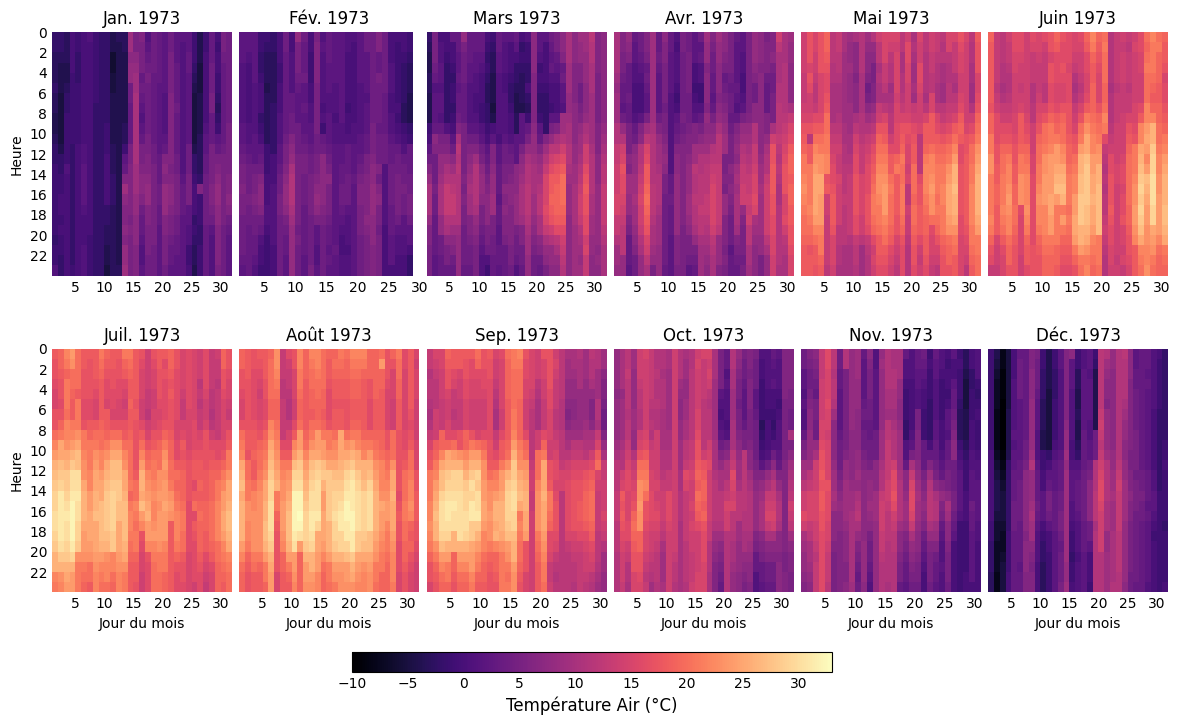

In [49]:
wthData['CurrentTime'] = pd.to_datetime(wthData['CurrentTime'])

MIN_TEMP = wthData["Température Air"].min()
MAX_TEMP = wthData["Température Air"].max()

fig, axes = plt.subplots(2, 6, figsize=(12, 8), sharey=True)

months1 = ['Jan. 1973','Fév. 1973','Mars 1973','Avr. 1973','Mai 1973','Juin 1973']
months2 = ['Juil. 1973','Août 1973','Sep. 1973','Oct. 1973','Nov. 1973','Déc. 1973']

for j, month in enumerate(range(1, 7)):
    temp_single_heatmap(wthData, month, 1973, axes[0, j],MIN_TEMP,MAX_TEMP)
    axes[0,j].set_title(months1[j])
for j, month in enumerate(range(7, 13)):
    temp_single_heatmap(wthData, month, 1973, axes[1, j],MIN_TEMP,MAX_TEMP)
    axes[1,j].set_title(months2[j])

axes[0,0].set_ylabel('Heure')
axes[1,0].set_ylabel('Heure')
for ax in axes[1]:
    ax.set_xlabel('Jour du mois')

# Adjust margin and space between subplots
# Extra space is on the left to add a label
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.3, wspace=0.04, bottom=0.2)

# Create a new axis to contain the color bar
cbar_ax = fig.add_axes([0.3, 0.10, 0.4, 0.025])

# Create a normalizer that goes from minimum to maximum temperature
norm = mc.Normalize(MIN_TEMP, MAX_TEMP)

# Create the colorbar and set it to horizontal
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap="magma"), 
    cax=cbar_ax, # Pass the new axis
    orientation = "horizontal"
)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label
cb.set_label("Température Air (°C)", size=12)

plt.show()

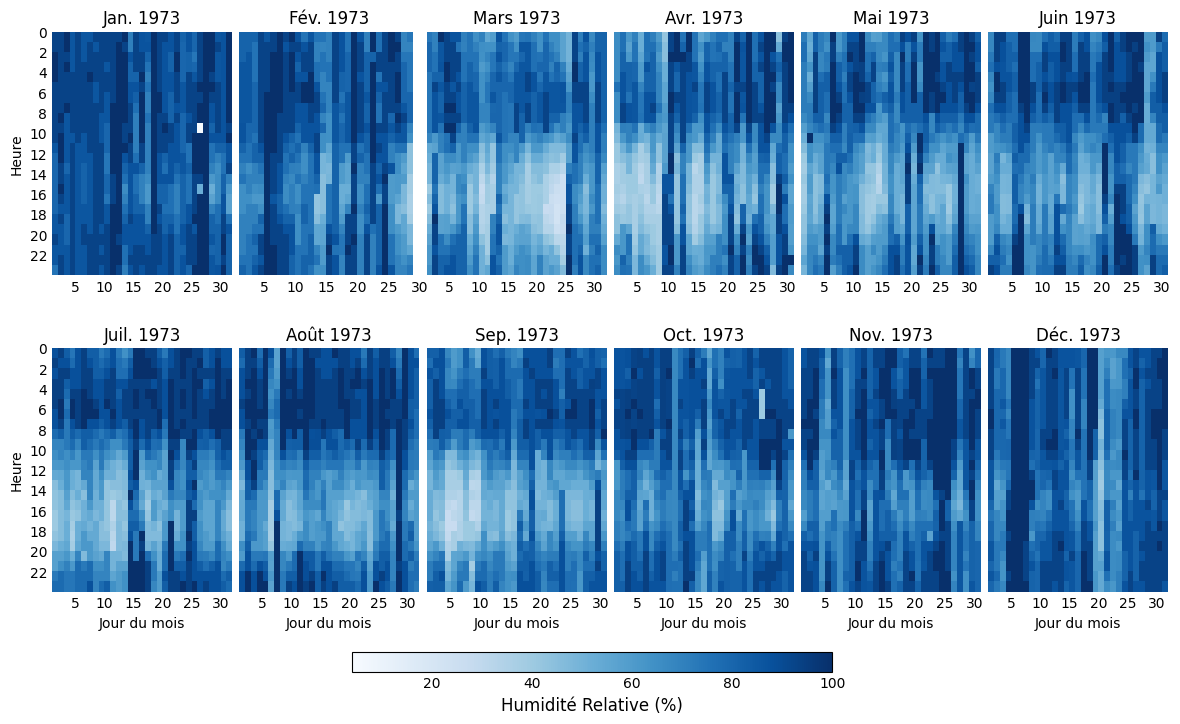

In [50]:
wthData['CurrentTime'] = pd.to_datetime(wthData['CurrentTime'])

MIN_HUMIDITY = wthData["Humidité Relative"].min()
MAX_HUMIDITY = wthData["Humidité Relative"].max()

fig, axes = plt.subplots(2, 6, figsize=(12, 8), sharey=True)

months1 = ['Jan. 1973','Fév. 1973','Mars 1973','Avr. 1973','Mai 1973','Juin 1973']
months2 = ['Juil. 1973','Août 1973','Sep. 1973','Oct. 1973','Nov. 1973','Déc. 1973']

for j, month in enumerate(range(1, 7)):
    humid_single_heatmap(wthData, month, 1973, axes[0, j],MIN_HUMIDITY,MAX_HUMIDITY)
    axes[0,j].set_title(months1[j])
for j, month in enumerate(range(7, 13)):
    humid_single_heatmap(wthData, month, 1973, axes[1, j],MIN_HUMIDITY,MAX_HUMIDITY)
    axes[1,j].set_title(months2[j])

axes[0,0].set_ylabel('Heure')
axes[1,0].set_ylabel('Heure')
for ax in axes[1]:
    ax.set_xlabel('Jour du mois')

# Adjust margin and space between subplots
# Extra space is on the left to add a label
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.3, wspace=0.04, bottom=0.2)

# Create a new axis to contain the color bar
cbar_ax = fig.add_axes([0.3, 0.10, 0.4, 0.025])

# Create a normalizer that goes from minimum to maximum temperature
norm = mc.Normalize(MIN_HUMIDITY, MAX_HUMIDITY)

# Create the colorbar and set it to horizontal
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap="Blues"), 
    cax=cbar_ax, # Pass the new axis
    orientation = "horizontal"
)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label
cb.set_label("Humidité Relative (%)", size=12)

plt.show()